# Inuk Song: Default Prediction
---
- American Express - Default Prediction 채무 불이행 예측
- 50만명의 데이터, 13번 측정
- 5개의 범주별로 188개의 컬정
- 총 500000 * 13 * 188 의 3차원 데이터
- Discussion에 데이터 용량을 줄이고 10개로 나눈 자료 있음
- https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054
- kaggle API: kaggle competitions download -c amex-default-prediction


## [1] 데이터 불러오기
---
- data_1, 3, 5 합쳐서 X, y 생성
- data 2, 4, 6 합쳐서 X_pred, y_pred 생성
- X, y 에서 랜덤 10000개 추출하여 모델 학습에 사용

In [1]:
# import mpdule
import pandas as pd
import numpy as np

In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Kaggle/default/data

/content/drive/MyDrive/Colab Notebooks/Kaggle/default/data


In [3]:
# load X data
X_raw1 = np.load("data_1.npy")
X_raw2 = np.load("data_3.npy")
X_raw3 = np.load("data_5.npy")

X_raw = np.concatenate([X_raw1, np.concatenate([X_raw2, X_raw3])])

# load y data
y1 = pd.read_parquet("targets_1.pqt")["target"]
y2 = pd.read_parquet("targets_3.pqt")["target"]
y3 = pd.read_parquet("targets_5.pqt")["target"]

y = pd.concat([y1, pd.concat([y2, y3])])

In [4]:
# load predict data
X_pred_raw1 = np.load("data_2.npy")
X_pred_raw2 = np.load("data_4.npy")
X_pred_raw3 = np.load("data_6.npy")

X_pred_raw = np.concatenate([X_pred_raw1, np.concatenate([X_pred_raw2, X_pred_raw3])])

y_pred1 = pd.read_parquet("targets_2.pqt")["target"]
y_pred2 = pd.read_parquet("targets_4.pqt")["target"]
y_pred3 = pd.read_parquet("targets_6.pqt")["target"]

y_pred = pd.concat([y_pred1, pd.concat([y_pred2, y_pred3])])

In [5]:
X_pred_raw.shape, y_pred.shape

((137673, 13, 188), (137673,))

## [2] 데이터 전처리
---

### [2-1] 훈련 데이터 전처리
- 10000개 추출

In [6]:
# 변경 전 shape 출력
print(f"X_train_raw.shape: {X_raw.shape}, X_test_raw.shape: {X_raw.shape}")
print(f"y_train_raw.shape: {y.shape}, y_test_raw.shape: {y.shape}")

X_train_raw.shape: (137673, 13, 188), X_test_raw.shape: (137673, 13, 188)
y_train_raw.shape: (137673,), y_test_raw.shape: (137673,)


In [7]:
# X 데이터 3차원에서 2차원 데이터로 변경
X = X_raw.reshape(X_raw.shape[0], 13 * 188)

# 변경 후 shape 출력
print(f"X_train_raw.shape: {X.shape}, X_test_raw.shape: {X.shape}")
print(f"y_train_raw.shape: {y.shape}, y_test_raw.shape: {y.shape}")

X_train_raw.shape: (137673, 2444), X_test_raw.shape: (137673, 2444)
y_train_raw.shape: (137673,), y_test_raw.shape: (137673,)


In [8]:
# min-max 스케일링
from sklearn.preprocessing import MinMaxScaler

X_scal = MinMaxScaler().fit_transform(X)

In [9]:
# 샘플 10000개 추출
df = pd.concat([pd.DataFrame(X_scal), pd.DataFrame(y).reset_index(drop=True)], axis=1)
df = df.sample(10000, random_state=42)

X_sample = np.array(df.iloc[:, :2444])
y_sample = np.array(df['target'])

In [10]:
# 10000개 샘플 데이터 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, stratify=y_sample, random_state=42, test_size=0.2
)

### [2-2] 예측 데이터 전처리

In [11]:
# 차원 변경 후 스케일
from sklearn.preprocessing import MinMaxScaler

X_pred = X_pred_raw.reshape(X_pred_raw.shape[0], 13 * 188)
X_pred_scal = MinMaxScaler().fit_transform(X_pred)

X_pred_scal.shape, y_pred.shape

((137673, 2444), (137673,))

## [3] feature 줄이기
---

### [3-1] ExtraTreesClassifier 활용한 feature 축소

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

model_ETC = ExtraTreesClassifier()
model_ETC.fit(X_train, y_train)
print(model_ETC.feature_importances_)

[0.00014406 0.00018867 0.00014679 ... 0.00021359 0.00032441 0.00022921]


In [13]:
print("ETC train score: ", model_ETC.score(X_train, y_train))
print("ETC test score: ", model_ETC.score(X_test, y_test))

ETC train score:  1.0
ETC test score:  0.875


In [14]:
select_SFM = SelectFromModel(model_ETC, threshold='median').fit(X_train,y_train)

# 훈련 데이터
X_train_SFM = select_SFM.transform(X_train)
X_test_SFM = select_SFM.transform(X_test)

# 예측 데이터
X_pred_SFM = select_SFM.transform(X_pred_scal)
# 원본 데이터
X_SFM = select_SFM.transform(X_scal)

In [15]:
print("feature 줄이기 전: ", X_train.shape, X_test.shape)
print("feature 줄인 후: ", X_train_SFM.shape, X_test_SFM.shape)

feature 줄이기 전:  (8000, 2444) (2000, 2444)
feature 줄인 후:  (8000, 1222) (2000, 1222)


In [16]:
model_ETC_SFM = ExtraTreesClassifier()
model_ETC_SFM.fit(X_train_SFM, y_train)

ExtraTreesClassifier()

In [17]:
print("ETC SFM train score: ", model_ETC_SFM.score(X_train_SFM, y_train))
print("ETC SFM test score: ", model_ETC_SFM.score(X_test_SFM, y_test))

ETC SFM train score:  1.0
ETC SFM test score:  0.875


### [3-2] 범주별 평균값으로 데이터 변경

In [18]:
def columns_dict():
    
    columns = ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_63', 'D_64', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'D_66', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'B_30', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'B_38', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']
    
    from collections import defaultdict
    legend = ["D", "S", "P", "B", "R"]
    # D_* = Delinquency variables
    # S_* = Spend variables
    # P_* = Payment variables
    # B_* = Balance variables
    # R_* = Risk variables
    
    result = defaultdict(list)
    
    for col in columns:
        if col[0] in legend:
            index = columns.index(col)
            result[col[0]].append(index)
            
    
    return result

In [19]:
def make_full_columns_dict(col_dict:dict, legend:list):
    from collections import defaultdict
    result = defaultdict()

    for i in legend:
        index_list = col_dict[i]
        base = np.array(col_dict[i])
        for j in range(1, 13):
            index_list = index_list + list(base + 188 * j)
        result[i] = index_list

    return result

In [20]:
col_dict = columns_dict()
legend = ["D", "S", "P", "B", "R"]

legend_index = make_full_columns_dict(col_dict, legend)

In [21]:
def make_mean_df(df:pd.DataFrame, legend_index:dict):
    from collections import defaultdict
    result = defaultdict()

    for i in legend_index.keys():
        result[i] = df.iloc[:, legend_index[i]].mean(axis=1)

    return pd.DataFrame(result)

In [22]:
# 훈련 데이터
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

X_train_mean = make_mean_df(X_train_df, legend_index).values
X_test_mean = make_mean_df(X_test_df, legend_index).values

# 예측 데이터
X_pred_df = pd.DataFrame(X_pred_scal)
X_pred_mean = make_mean_df(X_pred_df, legend_index).values

# 원본 데이터
X_df = pd.DataFrame(X_scal)
X_mean = make_mean_df(X_df, legend_index).values

In [23]:
print("범주별 평균값: ", X_train_mean.shape, X_test_mean.shape)

범주별 평균값:  (8000, 5) (2000, 5)


In [24]:
# ETC로 차이 확인
model_ETC_mean = ExtraTreesClassifier()
model_ETC_mean.fit(X_train_mean, y_train)

print("ETC mean train score: ", model_ETC_mean.score(X_train_mean, y_train))
print("ETC mean test score: ", model_ETC_mean.score(X_test_mean, y_test))

ETC mean train score:  1.0
ETC mean test score:  0.7645


### [3-3] 차원 축소

In [25]:
from sklearn.decomposition import TruncatedSVD

In [26]:
svc = TruncatedSVD(n_components=5)

# 훈련 데이터 
X_train_SVD = svc.fit_transform(X_train)
X_test_SVD = svc.fit_transform(X_test)

In [27]:
model_ETC_SVD = ExtraTreesClassifier()
model_ETC_SVD.fit(X_train_SVD, y_train)

ExtraTreesClassifier()

In [28]:
print("ETC SVD train score: ", model_ETC_SVD.score(X_train_SVD, y_train))
print("ETC SVD test score: ", model_ETC_SVD.score(X_test_SVD, y_test))

ETC SVD train score:  1.0
ETC SVD test score:  0.808


In [29]:
# 예측 데이터
X_pred_SVD = svc.fit_transform(X_pred_scal)

# 원본 데이터
X_SVD = svc.fit_transform(X_scal)

## [4] 모델 선택해서 학습 및 테스트
---

### [4-1] XGBoost 
---

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#### [4-1-1] SFM 데이터


In [31]:
# 데이터 나누기
X_train_SFM_2, X_val_SFM, y_train_SFM_2, y_val_SFM = train_test_split(
    X_train_SFM, y_train, stratify=y_train, random_state=42
)

In [32]:
# 모델 생성
model_xgb_SFM = xgb.XGBClassifier(
    n_jobs=-1,
    n_estimator=400,
    learning_rate=0.02,
    colsample_bytree=0.75,  # 각 트리마다 데이터 샘플링 비율
    max_depth=5,            # 트리의 최대 깊이
    min_child_weight=3,     # child에서 필요한 모든 관측치에 대한 가중치의 최소 
    reg_alpha=350           # 라쏘 가중치
)

In [33]:
# 모델 학습
model_xgb_SFM.fit(
    X_train_SFM_2,
    y_train_SFM_2,
    early_stopping_rounds=100,
    eval_metric='auc',
    eval_set=[(X_val_SFM, y_val_SFM)],
    verbose=0
)

XGBClassifier(colsample_bytree=0.75, learning_rate=0.02, max_depth=5,
              min_child_weight=3, n_estimator=400, n_jobs=-1, reg_alpha=350)

In [34]:
# 교차 검증
from sklearn.model_selection import cross_validate, cross_val_predict

cv_xgb_SFM = cross_validate(model_xgb_SFM, X_train_SFM, y_train, return_train_score=True)

In [35]:
pd.DataFrame(cv_xgb_SFM)

,fit_time,score_time,test_score,train_score
0,22.941341,0.014891,0.865625,0.880781
1,22.911066,0.014841,0.868125,0.880938
2,22.309641,0.014709,0.869375,0.885000
3,22.263581,0.014854,0.875625,0.882969
4,21.981523,0.016799,0.870000,0.879375


In [36]:
# 다른 데이터로 예측하기
print("xgb SFM original score: ", model_xgb_SFM.score(X_SFM, y))
print("xgb SFM predict score: ", model_xgb_SFM.score(X_pred_SFM, y_pred))

xgb SFM original score:  0.8720882090170186
xgb SFM predict score:  0.8483508022633341


#### [4-1-2] 범주별 평균화 데이터

In [37]:
# 데이터 나누기
X_train_mean_2, X_val_mean, y_train_mean_2, y_val_mean = train_test_split(
    X_train_mean, y_train, stratify=y_train, random_state=42
)

In [38]:
# # xgb모델 생성
# model_xgb_mean = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, verbosity=0)

# # 파라미터 리스트
# params = {
#     'max_depth':[3, 5, 7],
#     'min_child_weight':[1, 3],
#     'colsample_bytree':[0.5, 0.75],
#     'reg_alpha':[0.01, 0.1, 1, 10, 100]
# }

# # gridcv 객체 생성
# gridcv_mean = GridSearchCV(model_xgb_mean, param_grid=params, cv=5)

# # 모델 학습
# gridcv_mean.fit(X_train_mean_2, y_train_2, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_val_mean, y_val)])

In [39]:
# gridcv_mean.best_params_
best_params_mean = {
    'colsample_bytree': 0.75,
    'max_depth': 5,
    'min_child_weight': 3,
    'reg_alpha': 0.1
}

In [92]:
# 최적의 파라미터로 모델 생성
model_xgb_mean = xgb.XGBClassifier(
    n_jobs=-1,
    n_estimator=400,
    learning_rate=0.02,
    colsample_bytree=0.75,  # 각 트리마다 데이터 샘플링 비율
    max_depth=5,            # 트리의 최대 깊이
    min_child_weight=3,     # child에서 필요한 모든 관측치에 대한 가중치의 최소 
    reg_alpha=0.1           # 라쏘 가중치
)

In [93]:
# 모델 학습
model_xgb_mean.fit(
    X_train_mean_2,
    y_train_mean_2,
    early_stopping_rounds=100,
    eval_metric='auc',
    eval_set=[(X_val_mean, y_val_mean)],
    verbose=0
)

XGBClassifier(colsample_bytree=0.75, learning_rate=0.02, max_depth=5,
              min_child_weight=3, n_estimator=400, n_jobs=-1, reg_alpha=0.1)

In [94]:
# 교차 검증
cv_xgb_mean = cross_validate(model_xgb_mean, X_train_mean, y_train, return_train_score=True)

In [95]:
pd.DataFrame(cv_xgb_mean)

,fit_time,score_time,test_score,train_score
0,0.757672,0.003607,0.767500,0.799844
1,0.280246,0.003371,0.763125,0.800156
2,0.280070,0.003525,0.753750,0.802969
3,0.307565,0.005365,0.761875,0.799063
4,0.271881,0.003451,0.775625,0.799375


In [96]:
# 다른 데이터로 예측하기
print("XGD mean original score: ", model_xgb_mean.score(X_mean, y))
print("XGD mean predict score: ", model_xgb_mean.score(X_pred_mean, y_pred))

XGD mean original score:  0.7670712485382029
XGD mean predict score:  0.7601708395981783


#### [4-1-3] 차원축소(SVD) 데이터

In [45]:
# 데이터 나누기
X_train_SVD_2, X_val_SVD, y_train_SVD_2, y_val_SVD = train_test_split(
    X_train_SVD, y_train, stratify=y_train, random_state=42
)

In [46]:
# # xgb모델 생성
# model_xgb_SVD = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, verbosity=0)

# # 파라미터 리스트
# params = {
#     'max_depth':[3, 5, 7],
#     'min_child_weight':[1, 3],
#     'colsample_bytree':[0.5, 0.75],
#     'reg_alpha':[0.01, 0.1, 1, 10, 100]
# }

# # gridcv 객체 생성
# gridcv_SVD = GridSearchCV(model_xgb_SVD, param_grid=params, cv=5)

# # 모델 학습
# gridcv_SVD.fit(X_train_SVD_2, y_train_2, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_val, y_val)])

In [47]:
# 최적의 파라미터 출력
# gridcv_SVD.best_params_
best_parms_SVD = {
    'colsample_bytree': 0.75,
    'max_depth': 5,
    'min_child_weight': 3,
    'reg_alpha': 1
 }

In [87]:
# 최적의 파라미터로 모델 생성
model_xgb_SVD = xgb.XGBClassifier(
    n_jobs=-1,
    n_estimator=400,
    learning_rate=0.02,
    colsample_bytree=0.75,  # 각 트리마다 데이터 샘플링 비율
    max_depth=5,            # 트리의 최대 깊이
    min_child_weight=3,     # child에서 필요한 모든 관측치에 대한 가중치의 최소 
    reg_alpha=1          # 라쏘 가중치
)

In [88]:
# 모델 학습
model_xgb_SVD.fit(
    X_train_SVD_2,
    y_train_SVD_2,
    early_stopping_rounds=100,
    eval_metric='auc',
    eval_set=[(X_val_SVD, y_val_SVD)],
    verbose=0
)

XGBClassifier(colsample_bytree=0.75, learning_rate=0.02, max_depth=5,
              min_child_weight=3, n_estimator=400, n_jobs=-1, reg_alpha=1)

In [89]:
# 교차 검증
cv_xgb_SVD = cross_validate(model_xgb_SVD, X_train_SVD, y_train, return_train_score=True)

In [90]:
pd.DataFrame(cv_xgb_SVD)

,fit_time,score_time,test_score,train_score
0,0.285595,0.003310,0.825625,0.852031
1,0.274405,0.003279,0.831875,0.853125
2,0.279104,0.003325,0.838125,0.850938
3,0.328619,0.003281,0.820625,0.857031
4,0.278121,0.003289,0.824375,0.851406


In [91]:
# 다른 데이터로 예측하기
print("xgb SVD original score: ", model_xgb_SVD.score(X_SVD, y))
print("xgb SVD predict score: ", model_xgb_SVD.score(X_pred_SVD, y_pred))

xgb SVD original score:  0.8239015638505734
xgb SVD predict score:  0.8269885889026897


### [4-2] SGDClassifier
---


In [53]:
from sklearn.linear_model import SGDClassifier

#### [4-2-1] SFM 데이터

In [54]:
# 모델 생성 및 학습
model_SGD_SFM = SGDClassifier(
    alpha=0.45
)

model_SGD_SFM.fit(X_train_SFM, y_train)

SGDClassifier(alpha=0.45)

In [55]:
# 교차 검증
cv_SGD_SFM = cross_validate(model_SGD_SFM, X_train_SFM, y_train, return_train_score=True)

In [56]:
pd.DataFrame(cv_SGD_SFM)

,fit_time,score_time,test_score,train_score
0,0.236428,0.007081,0.856875,0.857812
1,0.281325,0.006248,0.863125,0.852031
2,0.234351,0.005936,0.843750,0.847031
3,0.235605,0.006002,0.853750,0.867031
4,0.235979,0.005908,0.846875,0.850938


In [57]:
# 다른 데이터 예측하기
print("SGD SFM origin score: ", model_SGD_SFM.score(X_SFM, y))
print("SGD SFM predict score: ", model_SGD_SFM.score(X_pred_SFM, y_pred))

SGD SFM origin score:  0.8537767027667008
SGD SFM predict score:  0.8553311106752958


#### [4-2-2] 범주별 평균화 데이터

In [58]:
# 모델 생성 및 학습
model_SGD_mean = SGDClassifier(
    alpha=0.00001
)

model_SGD_mean.fit(X_train_mean, y_train)

SGDClassifier(alpha=1e-05)

In [59]:
# 교차 검증
cv_SGD_mean = cross_validate(model_SGD_mean, X_train_mean, y_train, return_train_score=True)

In [60]:
pd.DataFrame(cv_SGD_mean)

,fit_time,score_time,test_score,train_score
0,0.039870,0.000770,0.733125,0.739844
1,0.045393,0.000987,0.736250,0.735938
2,0.058682,0.000968,0.745000,0.747812
3,0.043891,0.000989,0.755625,0.750625
4,0.048946,0.001011,0.735000,0.736875


In [61]:
# 다른 데이터로 평가하기
print("SGD mean origin score: ", model_SGD_mean.score(X_mean, y))
print("SGD mean predict score: ", model_SGD_mean.score(X_pred_mean, y_pred))

SGD mean origin score:  0.7502850958430484
SGD mean predict score:  0.7528200881799627


#### [4-2-3] 차원축소(SVD) 데이터

In [97]:
# 모델 생성 및 학습
model_SGD_SVD = SGDClassifier(
    alpha=0.01
)

model_SGD_SVD.fit(X_train_SVD, y_train)

SGDClassifier(alpha=0.01)

In [98]:
# 교차 검증
cv_SGD_SVD = cross_validate(model_SGD_SVD, X_train_SVD, y_train, return_train_score=True)

In [99]:
pd.DataFrame(cv_SGD_SVD)

,fit_time,score_time,test_score,train_score
0,0.017438,0.000800,0.796875,0.791094
1,0.017660,0.001152,0.834375,0.821719
2,0.012745,0.000957,0.814375,0.817969
3,0.022812,0.001080,0.801250,0.821250
4,0.020137,0.000990,0.818125,0.812656


In [100]:
# 다른 데이터로 예측하기
print("SGD SVD origin score: ", model_SGD_SVD.score(X_SVD, y))
print("SGD SVD predict score: ", model_SGD_SVD.score(X_pred_SVD, y_pred))

SGD SVD origin score:  0.8214101530438067
SGD SVD predict score:  0.8005999723983642


## [5] xgboost-SVD, SGDClassifier-SVD 비교
---

### [5-1] 교차검증 데이터 비교

In [66]:
# xgboost-SVD
pd.DataFrame(cv_xgb_SVD)

,fit_time,score_time,test_score,train_score
0,0.255816,0.003094,0.815000,0.840625
1,0.255913,0.003141,0.831875,0.840156
2,0.251216,0.003155,0.830625,0.839531
3,0.273323,0.003173,0.811250,0.843594
4,0.251919,0.003068,0.821875,0.840781


In [67]:
# SGDClassifier-SVD
pd.DataFrame(cv_SGD_SVD)

,fit_time,score_time,test_score,train_score
0,0.008180,0.000927,0.800625,0.797500
1,0.007957,0.000868,0.826875,0.819844
2,0.007330,0.000807,0.815000,0.817031
3,0.008540,0.000868,0.816875,0.824844
4,0.007922,0.000837,0.820625,0.820781


### [5-2] 예측 데이터 비교

In [68]:
print("xgb SVD original score: ", model_xgb_SVD.score(X_SVD, y))
print("xgb SVD predict score: ", model_xgb_SVD.score(X_pred_SVD, y_pred))
print("-----------------------------------------------------")
print("SGD SVD origin score: ", model_SGD_SVD.score(X_SVD, y))
print("SGD SVD predict score: ", model_SGD_SVD.score(X_pred_SVD, y_pred))

xgb SVD original score:  0.8221800934097463
xgb SVD predict score:  0.8234802757258141
-----------------------------------------------------
SGD SVD origin score:  0.8148801871100361
SGD SVD predict score:  0.8066360143237963


### [5-3] ROC AUC score 비교

In [81]:
from sklearn.metrics import roc_auc_score
rs_xgb = roc_auc_score(y_pred, model_xgb_SVD.predict(X_pred_SVD))
rs_SGD = roc_auc_score(y_pred, model_SGD_SVD.predict(X_pred_SVD))

In [82]:
print("xgb auc score: ", rs_xgb)
print("SGD auc score: ", rs_SGD)

xgb auc score:  0.757689666169446
SGD auc score:  0.7040067930674042


### [5-4] 혼동행렬 비교

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'xgboost SVD Confusion Matrix')

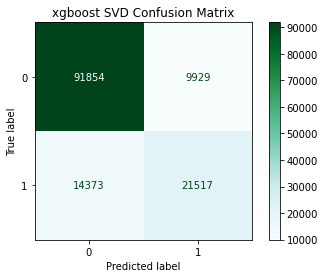

In [74]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plot = plot_confusion_matrix(model_xgb_SVD, # 분류 모델
                             X_pred_SVD, y_pred, # 예측 데이터와 예측값의 정답(y_true)
                             cmap=cm.BuGn, # 컬러맵
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None

plot.ax_.set_title('xgboost SVD Confusion Matrix')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SGDClassifier SVD Confusion Matrix')

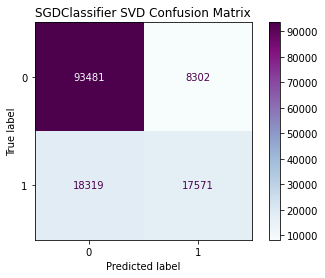

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plot = plot_confusion_matrix(model_SGD_SVD, # 분류 모델
                             X_pred_SVD, y_pred, # 예측 데이터와 예측값의 정답(y_true)
                             cmap=cm.BuPu, # 컬러맵
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None

plot.ax_.set_title('SGDClassifier SVD Confusion Matrix')